# Лабораторная работа №7

## 1. Выбор начальных условий
a.	Выбрать набор данных и обосновать его выбор.

Датасет - https://www.kaggle.com/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset, папка - adult tooth segmentation

Данный датасет выбран, так как он представляет реальные панорамные рентгеновские снимки зубов, что актуально для практических задач стоматологии. Сегментация зубов необходима для диагностики, планирования лечения и мониторинга состояния полости рта.

b.	Выбрать метрики качества и обосновать их выбор.

IoU — основная метрика для оценки качества сегментации, показывает степень пересечения предсказанных и истинных масок, что критично для точного выделения зубов

Dice Coefficient — чувствительна к ошибкам при малых объектах, таких как отдельные зубы

Pixel Accuracy — общая точность классификации пикселей

## 2.	Создание бейзлайна и оценка качества


In [1]:
!pip install torchmetrics --quiet
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet
!pip install segmentation-models-pytorch --quiet
!pip install kaggle --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.0 MB/s eta 0:00:00


In [2]:
import os, random, copy
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF
from sklearn.metrics import jaccard_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Загрузим датасет

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ketrum","key":"4f7898fa6bc17d128bca596c0fb2323f"}'}

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [5]:
!kaggle datasets download -d truthisneverlinear/childrens-dental-panoramic-radiographs-dataset
!unzip -q childrens-dental-panoramic-radiographs-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset
License(s): CC0-1.0
 98% 1.51G/1.55G [00:06<00:00, 246MB/s]
100% 1.55G/1.55G [00:06<00:00, 268MB/s]


Создадим класс для датасета

In [6]:
class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.imgs = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.bmp') or f.endswith('.png')])
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        mask_np = np.array(mask) > 0

        if self.transforms:
            transformed = self.transforms(image=np.array(img), mask=mask_np.astype(np.uint8))
            img_t  = transformed['image']
            mask_t = transformed['mask'].float()
        else:
            img_t = TF.to_tensor(img)
            mask_t = torch.tensor(mask_np, dtype=torch.float32)

        return img_t, mask_t


Примеры из датасета


In [ ]:
def show_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(8, 4 * num_examples))
    for i in range(num_examples):
        img_path = os.path.join(dataset.image_dir, dataset.imgs[i])
        mask_path = os.path.join(dataset.mask_dir, dataset.masks[i])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
myDataset = MyDataset("/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images", "/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks")

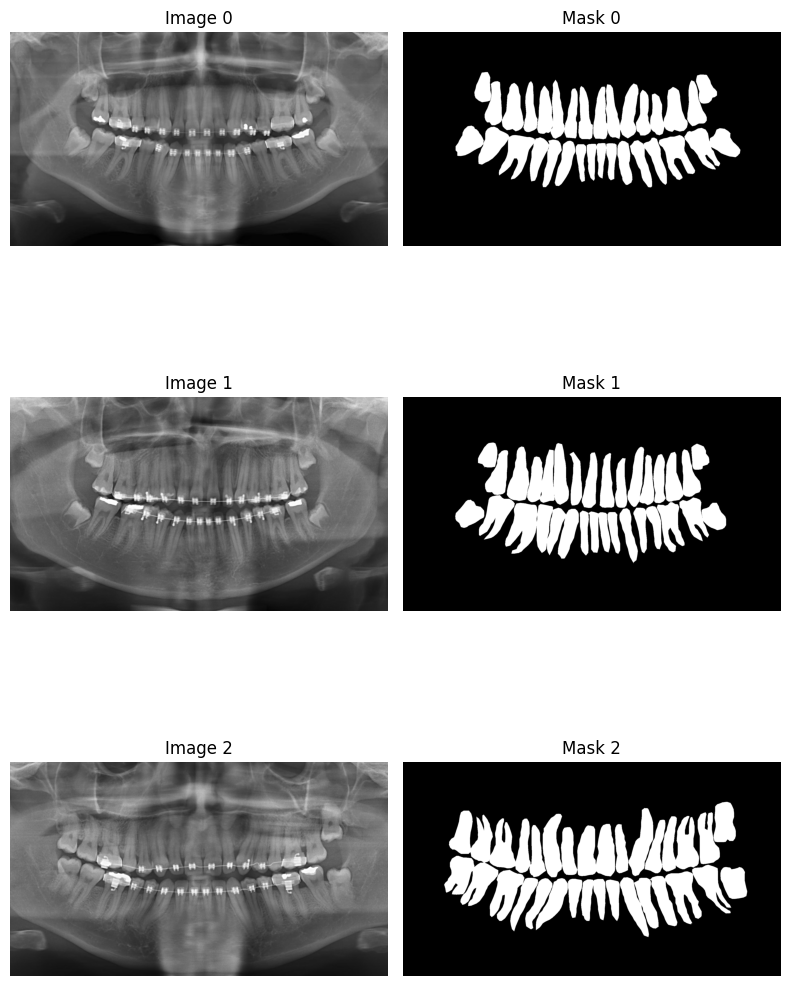

In [ ]:
show_examples(myDataset, 3)


Подготовим данные



In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Метрики

In [7]:
def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).int().cpu().numpy().flatten()
    targets = targets.int().cpu().numpy().flatten()
    return jaccard_score(targets, preds)

def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).int().cpu().numpy().flatten()
    targets = targets.int().cpu().numpy().flatten()
    return 2 * (np.sum(preds * targets)) / (np.sum(preds) + np.sum(targets) + 1e-8)

def f1_score_func(preds, targets, threshold=0.5):
    preds = (preds > threshold).int().cpu().numpy().flatten()
    targets = targets.int().cpu().numpy().flatten()
    return f1_score(targets, preds)

def pixel_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).int()
    correct = (preds == targets).int()
    accuracy = correct.sum().float() / torch.numel(correct)
    return accuracy.item()

### Сверточная модель

#### a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных

In [ ]:
model = segmentation_models_pytorch.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


Epoch [1/3], Loss: 0.35187927427444055


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


Epoch [2/3], Loss: 0.19987547365908928


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]

Epoch [3/3], Loss: 0.15351048841121348


#### b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:14<00:00,  2.01it/s]

IoU: 0.8055
Dice: 0.8917
Pixel_accuracy: 0.8552


### Трансформерная модель

#### a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных

In [ ]:
model = segmentation_models_pytorch.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch [1/3], Loss: 0.313604769554544


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch [2/3], Loss: 0.15778475413297086


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:39<00:00,  2.35it/s]

Epoch [3/3], Loss: 0.13705758354131212


#### b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных

In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')

[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]

IoU: 0.7576
Dice: 0.8616
Pixel_accuracy: 0.8569


## 3.	Улучшение бейзлайна

### Сверточная модель

#### a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)

1) Аугментация данных


2) Использование оптимизатора AdamW


3) Использование Dice Loss вместо Cross-Entropy


#### b. Проверить гипотезы

1) Аугментация данных

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:46<00:00,  2.01it/s]


Epoch [1/3], Loss: 0.47981162242432857


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


Epoch [2/3], Loss: 0.2912377860951931


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:49<00:00,  1.91it/s]

Epoch [3/3], Loss: 0.21996972789155675


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]

IoU: 0.7758
Dice: 0.8735
Pixel_accuracy: 0.8555


2) Использование оптимизатора AdamW


In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch [1/3], Loss: 0.38109541383195433


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch [2/3], Loss: 0.20860632588254643


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:49<00:00,  1.90it/s]

Epoch [3/3], Loss: 0.1552275184621202


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]

IoU: 0.8175
Dice: 0.8993
Pixel_accuracy: 0.8555


3) Использование Dice Loss вместо Cross-Entropy


In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = segmentation_models_pytorch.losses.DiceLoss(mode='binary')

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


Epoch [1/3], Loss: 0.3814969861761053


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


Epoch [2/3], Loss: 0.2244514467868399


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]

Epoch [3/3], Loss: 0.17040058399768584


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]

IoU: 0.7775
Dice: 0.8739
Pixel_accuracy: 0.8575


####  c. Сформировать улучшенный бейзлайн по результатам проверки гипотез

В результате проверки гипотез улучшение качества показала только замена оптимизатора Adam на AdamW

#### d. Обучить модели с улучшенным бейзлайном на выбранном наборе данных

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch [1/3], Loss: 0.38109541383195433


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch [2/3], Loss: 0.20860632588254643


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:49<00:00,  1.90it/s]

Epoch [3/3], Loss: 0.1552275184621202


#### e. Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных

In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]

IoU: 0.8175
Dice: 0.8993
Pixel_accuracy: 0.8555


#### f. Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2

Бейзлайн IoU: 0.8055
Dice: 0.8917
Pixel_accuracy: 0.8552

Улучшенный бейзлайн IoU: 0.8175
Dice: 0.8993
Pixel_accuracy: 0.8555

#### g. Сделать выводы

Таикм образом, с помощью гипотез удалось добится небольшого улучшения

### Трансформерная модель

#### a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)

1) Аугментация данных


2) Использование оптимизатора AdamW


3) Использование Dice Loss вместо Cross-Entropy

#### b. Проверить гипотезы

1) Аугментация данных

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


Epoch [1/3], Loss: 0.2128126343831103


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


Epoch [2/3], Loss: 0.14319612133376142


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]

Epoch [3/3], Loss: 0.13058195992353114


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]

IoU: 0.7524
Dice: 0.8582
Pixel_accuracy: 0.8578


2) Использование оптимизатора AdamW

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:40<00:00,  2.33it/s]


Epoch [1/3], Loss: 0.265883946513876


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


Epoch [2/3], Loss: 0.1492926448266557


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]

Epoch [3/3], Loss: 0.13121028815178162


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]

IoU: 0.7696
Dice: 0.8696
Pixel_accuracy: 0.8553


3) Использование Dice Loss вместо Cross-Entropy

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = segmentation_models_pytorch.losses.DiceLoss(mode='binary')

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:39<00:00,  2.35it/s]


Epoch [1/3], Loss: 0.23689810709750397


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch [2/3], Loss: 0.16212036444785746


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]

Epoch [3/3], Loss: 0.13984845673784296


In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]

IoU: 0.7348
Dice: 0.8460
Pixel_accuracy: 0.8550


####  c. Сформировать улучшенный бейзлайн по результатам проверки гипотез

В результате проверки гипотез улучшение качества показала только замена оптимизатора Adam на AdamW

#### d. Обучить модели с улучшенным бейзлайном на выбранном наборе данных

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = segmentation_models_pytorch.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:40<00:00,  2.33it/s]


Epoch [1/3], Loss: 0.265883946513876


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


Epoch [2/3], Loss: 0.1492926448266557


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]

Epoch [3/3], Loss: 0.13121028815178162


#### e. Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных

In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]

IoU: 0.7696
Dice: 0.8696
Pixel_accuracy: 0.8553


#### f. Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2

Бейзлайн IoU: 0.7576
Dice: 0.8616
Pixel_accuracy: 0.8569

Улучшенный бейзлайн IoU:
0.7696
Dice: 0.8696
Pixel_accuracy: 0.8553

#### g. Сделать выводы

Улучшенный бейзлайн показал лишь совсем небольшие улучшения

## 4. Имплементация алгоритма машинного обучения

### Сверточная модель

#### a. Самостоятельно имплементировать модели машинного обучения

In [41]:
import torch
import torch.nn as nn

class MyUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.down_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.up_transpose2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.up_transpose1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.out_conv = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        d1 = self.down_conv1(x)
        p1 = self.pool1(d1)

        d2 = self.down_conv2(p1)
        p2 = self.pool2(d2)

        bn = self.bottleneck(p2)

        #
        up2 = self.up_transpose2(bn)
        up2 = torch.cat([up2, d2], dim=1)
        up2 = self.up_conv2(up2)

        up1 = self.up_transpose1(up2)
        up1 = torch.cat([up1, d1], dim=1)
        up1 = self.up_conv1(up1)

        out = self.out_conv(up1)
        return out



#### b. Обучить имплементированные модели на выбранном наборе данных

In [33]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [34]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [36]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:48<00:00,  1.93it/s]


Epoch [1/3], Loss: 0.5672372617620103


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:48<00:00,  1.92it/s]


Epoch [2/3], Loss: 0.3972361388992756


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:47<00:00,  1.97it/s]

Epoch [3/3], Loss: 0.2662272383557989


#### c. Оценить качество имплементированных моделей по выбранным метрикам на выбранном наборе данных

In [37]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]

IoU: 0.6032
Dice: 0.7524
Pixel_accuracy: 0.8434


#### d. Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2

Бейзлайн IoU: 0.8055 Dice: 0.8917 Pixel_accuracy: 0.8552

Собственная реализация: IoU: 0.6032
Dice: 0.7524
Pixel_accuracy: 0.8434

#### e. Сделать выводы

Таким образом, собственная реализация оказалась хуже уже готовой Unet

#### f. Добавить техники из улучшенного бейзлайна (пункт 3с)

In [43]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [44]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyUNet(in_channels=3, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

#### g. Обучить модели для выбранных наборов данных

In [46]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:47<00:00,  1.96it/s]


Epoch [1/3], Loss: 0.528778425873594


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:47<00:00,  1.98it/s]


Epoch [2/3], Loss: 0.32483997877607956


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:46<00:00,  2.02it/s]

Epoch [3/3], Loss: 0.24693206142871937


#### h. Оценить качество моделей по выбранным метрикам на выбранном наборе данных

In [47]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]

IoU: 0.5893
Dice: 0.7413
Pixel_accuracy: 0.8445


#### i. Сравнить результаты моделей в сравнении с результатами из пункта 3


Улучшенный бейзлайн IoU: 0.8175 Dice: 0.8993 Pixel_accuracy: 0.8555

Улучшенная собственная реализация: IoU:0.5893
Dice: 0.7413
Pixel_accuracy: 0.8445

####  j. Сделать выводы

Таким образом, собственная реализация оказалась хуже уже готовой Unet

### Трансформерная модель

#### a. Самостоятельно имплементировать модели машинного обучения

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embed_dim=64, patch_size=16):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # B, N, C
        return x, (H, W)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class SimpleViTBackbone(nn.Module):
    def __init__(self, in_channels=3, embed_dim=64, depth=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, embed_dim)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim) for _ in range(depth)
        ])

    def forward(self, x):
        x, (H, W) = self.patch_embed(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.transpose(1, 2).reshape(-1, x.shape[-1], H, W)
        return x


class SegFormerDecoder(nn.Module):
    def __init__(self, embed_dim=64, out_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)
        self.up = nn.ConvTranspose2d(embed_dim // 2, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.up(x)
        return x


class mySegFormer(nn.Module):
    def __init__(self, in_channels=3, embed_dim=64, depth=4):
        super().__init__()
        self.encoder = SimpleViTBackbone(in_channels, embed_dim, depth)
        self.decoder = SegFormerDecoder(embed_dim, out_channels=1)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.decoder(features)
        logits = F.interpolate(logits, size=x.shape[2:], mode='bilinear', align_corners=False)
        return logits



#### b. Обучить имплементированные модели на выбранном наборе данных

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mySegFormer().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Epoch [1/3], Loss: 0.484115794618079


Epoch 2/3 [Train]: 100%|██████████| 94/94 [00:32<00:00,  2.92it/s]


Epoch [2/3], Loss: 0.4008208712998857


Epoch 3/3 [Train]: 100%|██████████| 94/94 [00:32<00:00,  2.87it/s]

Epoch [3/3], Loss: 0.3287874127322055


#### c. Оценить качество имплементированных моделей по выбранным метрикам на выбранном наборе данных

In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]

IoU: 0.4738
Dice: 0.6425
Pixel_accuracy: 0.8389


#### d. Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2

Бейзлайн IoU: 0.7576
Dice: 0.8616
Pixel_accuracy: 0.8569

Собственная реализация: IoU: 0.4738
Dice: 0.6425
Pixel_accuracy: 0.8389

#### e. Сделать выводы

Таким образом, собственная реализация оказалась хуже уже готовой Segformer

#### f. Добавить техники из улучшенного бейзлайна (пункт 3с)

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/images'
masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/train/masks'

train_dataset = MyDataset(images_dir, masks_dir, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_images_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/images'
test_masks_dir = '/content/Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks'

test_dataset = MyDataset(test_images_dir, test_masks_dir, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mySegFormer().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

#### g. Обучить модели для выбранных наборов данных

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,  masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch 1/3 [Train]: 100%|██████████| 94/94 [01:02<00:00,  1.50it/s]


Epoch [1/3], Loss: 0.6038804567874746


Epoch 2/3 [Train]: 100%|██████████| 94/94 [01:03<00:00,  1.49it/s]


Epoch [2/3], Loss: 0.46228318930940426


Epoch 3/3 [Train]: 100%|██████████| 94/94 [01:03<00:00,  1.49it/s]

Epoch [3/3], Loss: 0.4509715621775769


#### h. Оценить качество моделей по выбранным метрикам на выбранном наборе данных

In [ ]:
model.eval()
iou_list = []
dice_list = []
pa_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="[Test]"):
        images = images.to(device)
        masks = masks.to(device).float()
        outputs = model(images)
        output_probs = torch.sigmoid(outputs)
        iou = iou_score(output_probs, masks)
        dice = dice_score(output_probs, masks)
        pa = pixel_accuracy(output_probs, masks)
        iou_list.append(iou)
        dice_list.append(dice)
        pa_list.append(pa)

avg_iou = np.mean(iou_list)
avg_dice = np.mean(dice_list)
avg_pa = np.mean(pa_list)

print(f'IoU: {avg_iou:.4f}')
print(f'Dice: {avg_dice:.4f}')
print(f'Pixel_accuracy: {avg_pa:.4f}')



[Test]: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

IoU: 0.0380
Dice: 0.0729
Pixel_accuracy: 0.7878


#### i. Сравнить результаты моделей в сравнении с результатами из пункта 3


Улучшенный бейзлайн IoU: IoU: 0.7696 Dice: 0.8696 Pixel_accuracy: 0.8553

Улучшенная собственная реализация: IoU: 0.0380
Dice: 0.0729
Pixel_accuracy: 0.7878

####  j. Сделать выводы

Таким образом, собственная реализация оказалась хуже уже готовой Segformer, а улучшенный бейзлайн (оптимизатор AdamW)  сделал модель нерабочей